# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

Установите количество пропущенных значений поля <code>age</code>:

In [39]:
df = pd.read_csv('Data/titanic_train.csv')
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S,NaN
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,"Vancouver, BC"
979,3,0,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,"England New York, NY"


In [40]:
print(df.isnull().sum())
print('Число пропущенных щначений поля age: ', df.isnull().sum()['age'])

pclass         0
survived       0
name           0
sex            0
age          199
sibsp          0
parch          0
ticket         0
fare           0
cabin        769
embarked       0
home.dest    414
dtype: int64
Число пропущенных щначений поля age:  199


Определите долю выживших

In [41]:
df['survived'].mean()

0.382262996941896

Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [42]:
print(df.isnull().sum()/len(df))
columns_to_drop = ['cabin','home.dest','ticket']
df_droped = df.drop(columns_to_drop, axis=1)
df_droped.head(2)

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.202854
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000000
cabin        0.783894
embarked     0.000000
home.dest    0.422018
dtype: float64


,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [43]:
df_droped['fam_size'] = df_droped['sibsp'] + df_droped['parch']
df_droped = df_droped.drop(columns=['sibsp', 'parch'])
print('Финальное число признаков: ', df_droped.shape[1]-1)
print('Среднее колонки fam_size', df_droped['fam_size'].mean())
df_droped

Финальное число признаков:  7
Среднее колонки fam_size 0.8664627930682977


,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [44]:
from itertools import product
classes = [1, 2, 3]
gender = ['female', 'male']
prob_to_survive = {}
for cl, gn in product(classes, gender):
  prob_to_survive['{} & pclass:{}'.format(gn,cl)] = len(df[(df['pclass'] == cl) & (df['sex'] == gn) & df['survived'] == 1]) / len(df[(df['pclass'] == cl) & (df['sex'] == gn)])
prob_to_survive

{'female & pclass:1': 0.9711538461538461,
 'male & pclass:1': 0.33088235294117646,
 'female & pclass:2': 0.8461538461538461,
 'male & pclass:2': 0.15503875968992248,
 'female & pclass:3': 0.5030674846625767,
 'male & pclass:3': 0.16442048517520216}

Постройте гистограммы выжиших и невыживших по возрастам.

<Axes: xlabel='age', ylabel='Count'>

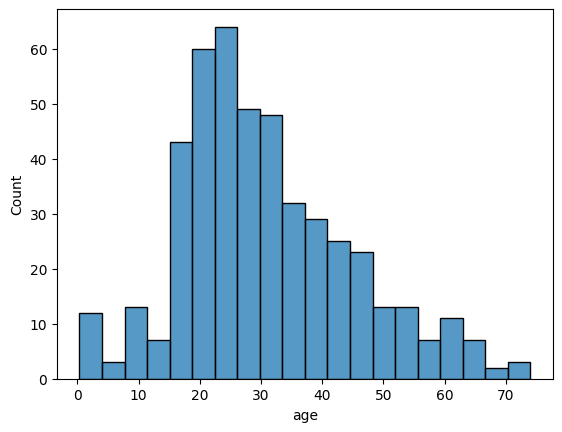

In [45]:
sns.histplot(data=df_droped[df_droped['survived'] == 0], x='age', bins=20)

<Axes: xlabel='age', ylabel='Count'>

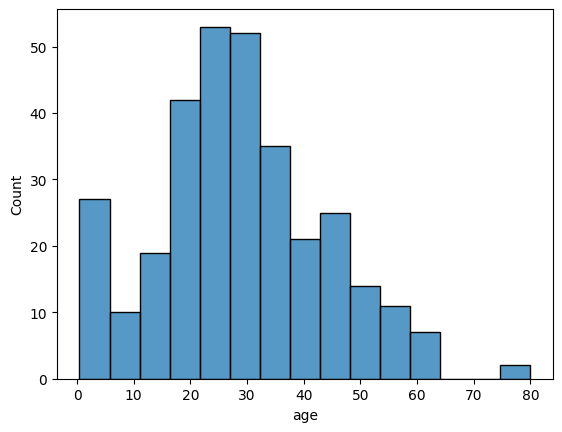

In [21]:
sns.histplot(data=df_droped[df_droped['survived'] == 1], x='age', bins=15)

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

random_state = 9

def build_model(df):
  X, y = df.drop('survived', axis=1), df['survived']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state
                                                      , stratify=y)
  lr = LogisticRegression(random_state=random_state, max_iter=1000).fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  f_1_score = f1_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, digits = 3)
  return f_1_score, report

cat_features = ['name', 'sex', 'embarked']
non_cat_features = list(set(df_droped.columns).difference(set(cat_features)))
score, report = build_model(df_droped[non_cat_features].dropna())
print('f1_score_drop_na', score)

f1_score_drop_na 0.5299145299145298


## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [47]:
from sklearn.impute import SimpleImputer
df_imputed_by_mean = df_droped[non_cat_features].fillna(df_droped[non_cat_features].mean()['age'])
score, report = build_model(df_imputed_by_mean)
print('f1_score_imputed_by_mean', score)

f1_score_imputed_by_mean 0.37254901960784315


## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [48]:
df_droped['honorific'] = list(df_droped['name'].str.extract('([A-Za-z]+)\.')[0])
pd.crosstab(df_droped['sex'], df_droped['honorific']).style.background_gradient()

honorific,Capt,Col,Countess,Don,Dona,Dr,Major,Master,Miss,Mlle,Mr,Mrs,Ms,Rev
sex,,,,,,,,,,,,,,
female,0,0,1,0,1,0,0,0,194,2,0,145,2,0
male,1,3,0,1,0,6,1,46,0,0,572,0,0,6


In [49]:
print('Число уникальных honorific:', len(df_droped['honorific'].unique()))
df_droped['honorific'].unique()

Число уникальных honorific: 14


array(['Miss', 'Mrs', 'Mr', 'Master', 'Mlle', 'Rev', 'Ms', 'Col', 'Dona',
       'Dr', 'Countess', 'Major', 'Don', 'Capt'], dtype=object)

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [60]:
df_droped['honorific'].\
replace(['Mlle', 'Rev', 'Ms', 'Col', 'Dona', 'Dr', 'Countess', 'Major', 'Don', 'Capt'],\
        ['Miss', 'Mr', 'Miss', 'Mr', 'Mrs', 'Mr', 'Mrs', 'Mr', 'Mr', 'Mr'], inplace=True)
pd.crosstab(df_droped['sex'], df_droped['honorific']).style.background_gradient()

honorific,Master,Miss,Mr,Mrs
sex,,,,
female,0,198,0,147
male,46,0,590,0


Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [61]:
print('Master_rate', len(df_droped[df_droped['honorific'] == 'Master']) / len(df_droped[df_droped['sex'] == 'male']))

Master_rate 0.07232704402515723


Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [62]:
dict(df_droped.groupby('honorific')['age'].mean())

{'Master': 5.128205128205129,
 'Miss': 22.000761538956446,
 'Mr': 32.90043763676149,
 'Mrs': 36.98425196850394}

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [54]:
df_droped.loc[(df_droped['age'].isnull()) & (df_droped['honorific'] == 'Master'), 'age'] = dict(df_droped.groupby('honorific')['age'].mean())['Master']
df_droped.loc[(df_droped['age'].isnull()) & (df_droped['honorific'] == 'Miss'), 'age'] = dict(df_droped.groupby('honorific')['age'].mean())['Miss']
df_droped.loc[(df_droped['age'].isnull()) & (df_droped['honorific'] == 'Mr'), 'age'] = dict(df_droped.groupby('honorific')['age'].mean())['Mr']
df_droped.loc[(df_droped['age'].isnull()) & (df_droped['honorific'] == 'Mrs'), 'age'] = dict(df_droped.groupby('honorific')['age'].mean())['Mrs']
print(df_droped.isnull().sum())

pclass       0
survived     0
name         0
sex          0
age          0
fare         0
embarked     0
fam_size     0
honorific    0
dtype: int64


In [55]:
df_imputed_by_honorific = df_droped.drop(columns=cat_features+['honorific'])
score, report = build_model(df_imputed_by_honorific)
print('f1_score_imputed_by_honorific', score)

f1_score_imputed_by_honorific 0.4


# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [56]:
df_droped_one_hot = df_droped.drop(columns=['name', 'honorific'])
df_droped_one_hot = pd.get_dummies(df_droped_one_hot, drop_first=True)
score, report = build_model(df_droped_one_hot)
print('f1_score_droped_one_hot', score)

f1_score_droped_one_hot 0.6666666666666667
